In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D,GlobalAveragePooling2D,Dense,Softmax,Flatten,MaxPooling2D,UpSampling2D,Dropout,Activation, Lambda, concatenate,BatchNormalization
from keras.datasets import cifar100, cifar10
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import kullback_leibler_divergence
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import categorical_accuracy
from keras import regularizers
from keras import optimizers
from keras import backend as K
import torch
import gc
#import seaborn as sns
import h5py
import sys

#import os
import pandas as pd
import keras
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Input, Add, BatchNormalization, Activation, Lambda
from keras.activations import relu, softmax
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
tf.config.run_functions_eagerly(True)

In [2]:
# Cifar100

num_classes_fine = 100
num_classes_coarse= 20
(x_train_100, y_train_f), (x_test_100, y_test_f) = cifar100.load_data()
#(x_train_100, y_train_coarse), (x_test_100, y_test_coarse) = cifar100.load_data(label_mode='coarse')


x_train_100 = x_train_100.astype('float32')
x_test_100 = x_test_100.astype('float32')

y_train_fine = to_categorical(y_train_f, num_classes_fine)
y_test_fine = to_categorical(y_test_f, num_classes_fine)
#y_train_coarse = to_categorical(y_train_coarse, num_classes_coarse)
#y_test_coarse = to_categorical(y_test_coarse, num_classes_coarse)

def normalize(X_train,X_test):
    mean = np.mean(X_train,axis=(0,1,2,3))
    std = np.std(X_train, axis=(0, 1, 2, 3))
    X_train = (X_train-mean)/(std+1e-7)
    X_test = (X_test-mean)/(std+1e-7)
    return X_train, X_test


x_train_100, x_test_100 = normalize(x_train_100, x_test_100)

print(f'x_train_100: {x_train_100.shape}     y_train_fine: {y_train_fine.shape} ')#    y_train_coarse: {y_train_coarse.shape}')
print(f'x_test_100: {x_test_100.shape}       y_test_fine: {y_test_fine.shape}   ')#    y_test_coarse: {y_test_coarse.shape}')

x_train_100: (50000, 32, 32, 3)     y_train_fine: (50000, 100) 
x_test_100: (10000, 32, 32, 3)       y_test_fine: (10000, 100)   


In [3]:
def teacher_model(num_classes):

    global Temperature, sgd_t, y_true, y_pred

    teacher= Sequential()

    #teacher.add(Conv2D(64,(3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.0005), input_shape= (32,32,3)))
    #teacher.add(BatchNormalization())
    #teacher.add(Dropout(0.3))

    #teacher.add(Conv2D(64,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    #teacher.add(BatchNormalization()) 

    #teacher.add(MaxPooling2D(pool_size=(2,2)))

    #teacher.add(Conv2D(128,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    #teacher.add(BatchNormalization())
    #teacher.add(Dropout(0.4))

    #teacher.add(Conv2D(128,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    #teacher.add(BatchNormalization())

    #teacher.add(MaxPooling2D(pool_size=(2,2)))

    teacher.add(Conv2D(256,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005), input_shape= (8,8,128)))
    teacher.add(BatchNormalization())
    teacher.add(Dropout(0.4))

    teacher.add(Conv2D(256,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    teacher.add(BatchNormalization())
    teacher.add(Dropout(0.4))

    teacher.add(Conv2D(256,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005), input_shape= (8,8,256)))
    teacher.add(BatchNormalization()) 

    teacher.add(MaxPooling2D(pool_size=(2,2)))

    teacher.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005), input_shape= (4,4,256)))
    teacher.add(BatchNormalization())
    teacher.add(Dropout(0.4))

    teacher.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    teacher.add(BatchNormalization())
    teacher.add(Dropout(0.4))

    teacher.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    teacher.add(BatchNormalization())


    teacher.add(MaxPooling2D(pool_size=(2,2)))

    teacher.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    teacher.add(BatchNormalization())
    teacher.add(Dropout(0.4))

    teacher.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    teacher.add(BatchNormalization())
    teacher.add(Dropout(0.4))

    teacher.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    teacher.add(BatchNormalization())

    teacher.add(MaxPooling2D(pool_size=(2,2)))
    teacher.add(Dropout(0.5))

    teacher.add(Flatten())
    teacher.add(Dense(128, kernel_regularizer=regularizers.l2(0.0005)))
    teacher.add(Activation('relu'))
    teacher.add(BatchNormalization())
    teacher.add(Dropout(0.5))
    teacher.add(Dense(128))
    teacher.add(Activation('relu'))
    teacher.add(Dropout(0.5))

    teacher.add(Dense(num_classes))
    #teacher.add(Activation('softmax'))


    logits= teacher.layers[-1].output
    probs= Activation('softmax')(logits)
    logits_T= Lambda(lambda x:x/Temperature)(logits)
    probs_T= Activation('softmax')(logits_T)

    CombinedLayers= concatenate([probs, probs_T])
    teacher= Model(teacher.input, CombinedLayers)

    teacher.compile(optimizer=sgd_t, loss=lambda y_true,y_pred: teacher_loss(y_true, y_pred), metrics=teacher_metric)


    return teacher

In [4]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
tf.get_logger().setLevel('ERROR')


def student_model(num_classes):
    
    global sgd_s, y_true, y_pred, Temperature, Alpha
    inputs= Input((32,32,3))

    x= Conv2D(64,(3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.0005), input_shape=(32,32,3))(inputs)
    x= BatchNormalization()(x)
    x= Dropout(0.3)(x)

    x= Conv2D(64,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005))(x)
    x= BatchNormalization()(x) 

    x=MaxPooling2D(pool_size=(2,2))(x)

    x=Conv2D(128,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005))(x)
    x=BatchNormalization()(x)
    x=Dropout(0.4)(x)

    x=Conv2D(128,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005))(x)
    x=BatchNormalization()(x)

    hidden=MaxPooling2D(pool_size=(2,2))(x)
    
    hidden2=tf.stop_gradient(hidden)
    
    # Classifier
    x=Flatten()(hidden)
    x=Dense(128, kernel_regularizer=regularizers.l2(0.0005))(x)
    x=Activation('relu')(x)
    x=BatchNormalization()(x)
    x=Dropout(0.5)(x)
    x=Dense(128, kernel_regularizer=regularizers.l2(0.0005))(x)
    x=Activation('relu')(x)
    x=Dropout(0.5)(x)

    out=Dense(num_classes)(x)

    out_c= Activation('softmax')(out)                     # hard prediction
    logits_T= Lambda(lambda x:x/Temperature)(out)         #z/T
    probs_T= Activation('softmax')(logits_T)                         # soft prediction

    CombinedLayers= concatenate([out_c, probs_T])
    
    
    ### Decoder1 
    d= Conv2D(12,(3,3), strides=(1,1))(hidden)
    d=Activation('relu')(d)
    d=keras.layers.ZeroPadding2D(padding=6)(d)
    d=BatchNormalization()(d)
    d=Conv2D(3,(3,3), strides=(1,1))(d)
    d=keras.layers.ZeroPadding2D(padding=8)(d)
    d=Activation('sigmoid')(d)
    out_d=BatchNormalization()(d)
    
    d2= Conv2D(12,(3,3), strides=(1,1))(hidden2)
    d2=Activation('relu')(d2)
    d2=keras.layers.ZeroPadding2D(padding=6)(d2)
    d2=BatchNormalization()(d2)
    d2=Conv2D(3,(3,3), strides=(1,1))(d2)
    d2=keras.layers.ZeroPadding2D(padding=8)(d2)
    d2=Activation('sigmoid')(d2)
    out_d2=BatchNormalization()(d2)
    
    
    ### Decoder2 (논문에서 사용)
#     def resize(hidden):
#         return tf.image.resize(hidden, (32,32), method=tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio=True)
#     cv1=Conv2D(12,(3,3), strides=(1,1), padding='same', kernel_initializer=initializer)
#     bn1=BatchNormalization()
#     act1= Activation('relu')
#     cv2= Conv2D(3, (3,3), strides=(1,1), padding='same')
#     act2= Activation('sigmoid')
    
    
#     d= resize(hidden)
#     d= cv1(d)
#     d= bn1(d)
#     d= act1(d)
#     d= cv2(d)
#     out_d= act2(d)  # student+decoder

#     d2= resize(hidden2)
#     d2= cv1(d2)
#     d2= bn1(d2)
#     d2= act1(d2)
#     d2= cv2(d2)
#     out_d2= act2(d2)  # decoder 만


#     student= Model(inputs, [out_d2, out_d, CombinedLayers])
#     student.compile(optimizer=sgd_s, loss=[loss_decoder, loss_student_decoder, loss_classifier], metrics=[metric_decoder, metric_student_decoder, metric_classifier])

    student=Model(inputs, [out_d, CombinedLayers])
    student.compile(optimizer=sgd_s, loss=[loss_student_decoder, loss_classifier], metrics=[metric_student_decoder, metric_classifier])

    return student


In [ ]:
class supervised_nt_xent_loss(keras.losses.Loss):
    def __init__(self,temperature=1, name=None):
        super(supervised_nt_xent_loss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self,  labels, feature_vectors, sample_weight=None):

        base_temperature = 1

        feature_vectors=tf.math.l2_normalize(feature_vectors, axis=1)
        batch_size= tf.shape(feature_vectors)[0]
        
        contrast_count=1
        anchor_count=contrast_count
        labels= tf.expand_dims(labels,-1)

        # mask는 [batch_size, batch_size] dim이고, mask[i,j]=1 if i랑 j의 class 같으면
        mask= tf.cast(tf.equal(labels, tf.transpose(labels)), tf.float32)
        mask= tf.reshape(mask, (mask.shape[0], mask.shape[0]))#
        anchor_dot_contrast= tf.divide(tf.matmul(feature_vectors, tf.transpose(feature_vectors)), self.temperature)
        
        # for numerical stability
        logits_max= tf.reduce_max(anchor_dot_contrast, axis=1, keepdims=True)
        logits= anchor_dot_contrast - logits_max

        # tile mask 
        logits_mask= tf.ones_like(mask) - tf.eye(batch_size)  #eye는 가운데 eigen
        mask= mask*logits_mask   # mask 가 class 같으면 1이였고, 아예 데이터 같은건 뺐음 (빼야 연산돼. 어차피 다른 데이터 128개씩 들어가니까)
        
        # compute log_prob
        exp_logits= tf.exp(logits)*logits_mask
        log_prob= logits - tf.math.log(tf.reduce_sum(exp_logits, axis=1, keepdims=True))  #(128,128)

        # compute mean of log-likelihood over positive 
        mask_sum = tf.reduce_sum(mask, axis=1)  #(128,)
        mean_log_prob_pos= tf.reduce_sum(mask*log_prob, axis=1)[mask_sum>0] / mask_sum[mask_sum>0]
          # maxk_num 이 0보다 큰거만 세. 128개 안에 자기랑 같은 class인 개수 셈 그거들만 정리한거.
 

        #loss
        loss= -(self.temperature/base_temperature)*mean_log_prob_pos 

        #원래 mean_log_prob_pos 가 뭐길래 base temp 를 나눠서 곱하지 대충7 정도 값을 곱하는거 같음
        loss= tf.reduce_mean(loss)

        return loss

In [5]:
def loss_decoder(y_true, y_pred):
    #loss= keras.losses.binary_crossentropy(y_true, y_pred)
    loss= keras.losses.binary_crossentropy(y_true, y_pred)
    return loss
def metric_decoder(y_true, y_pred):
    metric= keras.metrics.binary_accuracy(y_true, y_pred)
    return metric


def loss_student_decoder(y_true, y_pred):
    loss= keras.losses.binary_crossentropy(y_true, y_pred)
    #loss= kullback_leibler_divergence(y_true, y_pred)
    
    m= (y_true+y_pred)/2
    jsloss= (kullback_leibler_divergence(y_true, m) + kullback_leibler_divergence(y_pred, m))/2
    
    return loss
def metric_student_decoder(y_true, y_pred):
    #metric= keras.metrics.binary_accuracy(y_true, y_pred)
    metric= keras.metrics.categorical_accuracy(y_true, y_pred)
    return metric



def loss_classifier(y_true, y_pred):
    global num_classes_s, Alpha, Beta, Temperature
    y_true, y_true_soft= y_true[:,:num_classes_s], y_true[:, num_classes_s:]
    y_pred, y_pred_soft= y_pred[:,:num_classes_s], y_pred[:, num_classes_s:]
   
    #cross-entropy loss (temperatureX)
    CE_loss= keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.AUTO, from_logits=False)(y_true,y_pred)
      
    #KL-divergence loss (temperatureO)
    KL_loss = (Temperature**2)*(kullback_leibler_divergence(y_true_soft, y_pred_soft))
    
 
    return Alpha*CE_loss + Beta*KL_loss

def metric_classifier(y_true, y_pred):
    y_true, y_true_soft= y_true[:,:num_classes_s], y_true[:, num_classes_s:]
    y_pred, y_pred_soft= y_pred[:,:num_classes_s], y_pred[:, num_classes_s:]
    metric= keras.metrics.categorical_accuracy(y_true, y_pred)
    return metric

In [6]:
def teacher_loss(y_true, y_pred):
    global count, num_classes_t, pred_sum, pred_avg, batchsize
    y_true, y_true_soft= y_true[:,:num_classes_t], y_true[:, num_classes_t:]
    y_pred, y_pred_soft= y_pred[:,:num_classes_t], y_pred[:, num_classes_t:]

    #(y_pred,y_pred_soft) = tf.split(y_pred,num_or_size_splits = 2, axis = 1)
    #(y_true,y_true_soft) = tf.split(y_true,num_or_size_splits = 2, axis = 1)

    loss= keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.AUTO, from_logits=False)(y_true,y_pred)

    y_pred_soft_np=K.eval(y_pred_soft)
    y_true_np= K.eval(y_true)
 
    for i in range(y_pred_soft_np.shape[0]):  #(128,100)
        label= np.argmax(y_true_np[i])    
        pred_sum[label]= pred_sum[label] + y_pred_soft_np[i]
        count[label]= count[label]+1
        #print('\\ni: ', i)
        #print('label: ',label)
        #print('true_soft argmax: ', np.argmax(y_true_soft_np[i]))   
        #print('hard prediction for the batch: ', np.argmax(y_pred_np[i]))  
        #print('pred_sum[label] argmax: ', np.argmax(pred_sum[label]))
        #print('pred argmax > pred label?: ', np.argmax(y_pred_soft_np[i])>y_pred_soft_np[i,label])
 
    return 2*loss


def teacher_metric(y_true, y_pred):
    global count, num_classes_t, pred_sum, pred_avg, batchsize
    y_true, y_true_soft= y_true[:,:num_classes_t], y_true[:, num_classes_t:]
    y_pred, y_pred_soft= y_pred[:,:num_classes_t], y_pred[:, num_classes_t:]
    
    metric= keras.metrics.categorical_accuracy(y_true,y_pred)

    return metric

In [7]:
def distillation(student_epoch, teacher_epoch, iteration, batch_size, temperature):
    global count, Temperature, Alpha, Beta, pred_sum, pred_avg, sgd_t, sgd_s, num_classes_s, num_classes_t, batchsize, history_s, history_t
    
    s_d_val_loss = np.empty(student_epoch*iteration)
    s_d_val_acc = np.empty(student_epoch*iteration)
    t_d_val_loss = np.empty(teacher_epoch*iteration)
    t_d_val_acc = np.empty(teacher_epoch*iteration)
       
    #params
    Temperature= temperature
    #Alpha= alpha
    num_classes_s = num_classes_fine
    num_classes_t= num_classes_fine
    lr_t= 0.01
    lr_s= 0.001
    lr_decay= 1e-6
    batchsize=batch_size
    weight_decay= 0.0005
    lr_drop=20
    pred_avg=np.zeros(num_classes_t) 
    
        
    #models
    sgd_t= optimizers.SGD(learning_rate= lr_t, decay= lr_decay, momentum=0.9, nesterov=True)
    sgd_s= optimizers.Adam(learning_rate= lr_s)
    teacher= teacher_model(num_classes_t)
    student= student_model(num_classes_s)
      
    
    for i in range(iteration):
        if i==0:
            Alpha=2
            Beta=0
        elif i<5:
            Alpha=1
            Beta=1
        else:
            Alpha=1
            Beta=2
     
        
        #student training
        print(f'student {i+1}th training')           

              
                
        def lr_scheduler(student_epoch):
            return lr_s * (0.5 ** (student_epoch // lr_drop))
        reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)

        y_train_soft= np.zeros((x_train_100.shape[0],num_classes_t))

        for index in range(x_train_100.shape[0]):
            label= np.argmax(y_train_fine[index])
            y_train_soft[index]= pred_avg[label]
        y_train_new= np.c_[y_train_fine, y_train_soft]
           
#         history_s= student.fit(x_train_100, [x_train_100, x_train_100, y_train_new], batch_size=batchsize,
#                                epochs= student_epoch, callbacks=[reduce_lr],
#                                validation_split=0.2, shuffle=False, verbose=2)
        history_s= student.fit(x_train_100, [x_train_100, y_train_new], batch_size=batchsize,
                               epochs= student_epoch, callbacks=[reduce_lr],
                               validation_split=0.2, shuffle=False, verbose=2)
         
        for e in range(student_epoch):
            s_d_val_loss[i*student_epoch +e]= history_s.history['val_loss'][e]
            s_d_val_acc[i*student_epoch +e]= history_s.history[list(iter(history_s.history))[-2]][e]
        
        
        # Plot
        if i==2 or i==iteration-1:
            student_hidden= Model(inputs=student.input, outputs= student.layers[12].output)

            pic=x_train_100[5000]
            pic = np.expand_dims(pic, axis=0)
            feature= student_hidden.predict(pic)

            square=8
            ix=1
            for fmap in feature:
                for _ in range(square):
                    for _ in range(square):
                        ax= plt.subplot(square, square, ix)
                        ax.set_xticks([])
                        ax.set_yticks([])
                        plt.rcParams["figure.figsize"] = (8,8)
                        plt.imshow(fmap[:,:,ix-1])
                        ix=ix+1
            plt.rcParams["figure.figsize"] = (14,4)
            print('{}th iteration'.format(i))
            plt.show()
          



        #teacher training
        count=np.zeros(num_classes_t, dtype=np.int)
        pred_sum=np.zeros((num_classes_t, num_classes_t))
        pred_avg=np.zeros((num_classes_t, num_classes_t))  #initialize
#         pred_sum=np.zeros((128, 128))
#         pred_avg=np.zeros((128, 128))  #initialize
     
        def lr_scheduler(teacher_epoch):
            return lr_t * (0.5 ** (teacher_epoch // lr_drop))
        reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)
            
        out_s= Model(inputs= student.input, outputs= student.layers[12].output)
        x_1= x_train_100[:10000]
        s_1= out_s.predict(x_1, batch_size=2)
        
        x_2= x_train_100[10000:20000]
        s_2= out_s.predict(x_2, batch_size=2)
        s_output= np.vstack([s_1,s_2])

        x_3= x_train_100[20000:30000]
        s_3= out_s.predict(x_3, batch_size=2)
        s_output= np.vstack([s_output,s_3])
       
        x_4= x_train_100[30000:40000]
        s_4= out_s.predict(x_4, batch_size=2)
        s_output= np.vstack([s_output,s_4])
   
        x_5= x_train_100[40000:50000]
        s_5= out_s.predict(x_5, batch_size=2)
        s_output= np.vstack([s_output,s_5])
       



        y_train_new= np.c_[y_train_fine, y_train_fine]
            
        print(f'teacher {i+1}th training')
        history_t= teacher.fit(s_output, y_train_new, batch_size= batchsize,
                               epochs= teacher_epoch, callbacks=[reduce_lr],
                               validation_split=0.2, shuffle=False, verbose=2)
        
            
        #바로 직전 iter의 pred만 student한테 줄때 이 loop안에서 초기화
        for classes in range(num_classes_t):
             pred_avg[classes]= pred_sum[classes]/count[classes]
        '''
        #학습 된 후 output뽑아서 label별 평균
        output= history_t.predict(s_output, batch_size=2)
        for classes in range(num_classes_t):
            label= np.argmax(y_train_fine[classes])
            pred_sum[label]= pred_sum[label]+ output[classes]
            count[classes]= count[classes]+1
        pred_avg[classes]=
        #loss바꿔야돼
        '''
            
        #모든걸 누적. count 로 나누면 안됌 이전에 count 랑 다시 곱한다음에 pred_sum 또 추출해서 더하든지
        
        for e in range(teacher_epoch):
            t_d_val_loss[i*teacher_epoch +e]= history_t.history['val_loss'][e]
            t_d_val_acc[i*teacher_epoch +e]= history_t.history['val_teacher_metric'][e]
                
    return student, teacher, s_d_val_loss, s_d_val_acc, t_d_val_loss, t_d_val_acc

student 1th training


C:\Users\hyeli\Anaconda3\envs\hlnam\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3508: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/9
313/313 - 28s - loss: 9.0347 - batch_normalization_16_loss: -2.1796e-01 - concatenate_1_loss: 8.8992 - batch_normalization_16_metric_student_decoder: 0.3892 - batch_normalization_16_metric_classifier: 0.3892 - concatenate_1_metric_student_decoder: 0.0482 - concatenate_1_metric_classifier: 0.0482 - val_loss: 9.1377 - val_batch_normalization_16_loss: -3.2059e-01 - val_concatenate_1_loss: 9.1039 - val_batch_normalization_16_metric_student_decoder: 0.5316 - val_batch_normalization_16_metric_classifier: 0.5316 - val_concatenate_1_metric_student_decoder: 0.0256 - val_concatenate_1_metric_classifier: 0.0256
Epoch 2/9
313/313 - 23s - loss: 8.0667 - batch_normalization_16_loss: -4.2097e-01 - concatenate_1_loss: 8.1129 - batch_normalization_16_metric_student_decoder: 0.5028 - batch_normalization_16_metric_classifier: 0.5028 - concatenate_1_metric_student_decoder: 0.0783 - concatenate_1_metric_classifier: 0.0783 - val_loss: 7.8711 - val_batch_normalization_16_loss: -4.7758e-01 - val_con

Epoch 3/9
313/313 - 23s - loss: 3.6370 - batch_normalization_16_loss: -6.6305e-01 - concatenate_1_loss: 3.9303 - batch_normalization_16_metric_student_decoder: 0.5442 - batch_normalization_16_metric_classifier: 0.5442 - concatenate_1_metric_student_decoder: 0.2225 - concatenate_1_metric_classifier: 0.2225 - val_loss: 3.2593 - val_batch_normalization_16_loss: -7.1407e-01 - val_concatenate_1_loss: 3.6060 - val_batch_normalization_16_metric_student_decoder: 0.5431 - val_batch_normalization_16_metric_classifier: 0.5431 - val_concatenate_1_metric_student_decoder: 0.2769 - val_concatenate_1_metric_classifier: 0.2769
Epoch 4/9
313/313 - 23s - loss: 3.6090 - batch_normalization_16_loss: -6.5704e-01 - concatenate_1_loss: 3.8975 - batch_normalization_16_metric_student_decoder: 0.5457 - batch_normalization_16_metric_classifier: 0.5457 - concatenate_1_metric_student_decoder: 0.2256 - concatenate_1_metric_classifier: 0.2256 - val_loss: 3.2681 - val_batch_normalization_16_loss: -7.0639e-01 - val_con

Epoch 5/9
313/313 - 23s - loss: 4.5255 - batch_normalization_16_loss: -7.0977e-01 - concatenate_1_loss: 4.5352 - batch_normalization_16_metric_student_decoder: 0.5492 - batch_normalization_16_metric_classifier: 0.5492 - concatenate_1_metric_student_decoder: 0.2858 - concatenate_1_metric_classifier: 0.2858 - val_loss: 4.0967 - val_batch_normalization_16_loss: -7.6538e-01 - val_concatenate_1_loss: 4.1478 - val_batch_normalization_16_metric_student_decoder: 0.5516 - val_batch_normalization_16_metric_classifier: 0.5516 - val_concatenate_1_metric_student_decoder: 0.3238 - val_concatenate_1_metric_classifier: 0.3238
Epoch 6/9
313/313 - 23s - loss: 4.4769 - batch_normalization_16_loss: -7.1240e-01 - concatenate_1_loss: 4.4618 - batch_normalization_16_metric_student_decoder: 0.5500 - batch_normalization_16_metric_classifier: 0.5500 - concatenate_1_metric_student_decoder: 0.2957 - concatenate_1_metric_classifier: 0.2957 - val_loss: 4.1209 - val_batch_normalization_16_loss: -7.5287e-01 - val_con

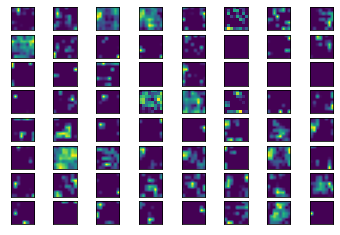

teacher 3th training
Epoch 1/15
313/313 - 22s - loss: 5.9212 - teacher_metric: 0.3935 - val_loss: 5.9521 - val_teacher_metric: 0.4211
Epoch 2/15
313/313 - 22s - loss: 5.5454 - teacher_metric: 0.4315 - val_loss: 5.9381 - val_teacher_metric: 0.4337
Epoch 3/15
313/313 - 22s - loss: 5.3877 - teacher_metric: 0.4478 - val_loss: 5.9596 - val_teacher_metric: 0.4340
Epoch 4/15
313/313 - 22s - loss: 5.3055 - teacher_metric: 0.4626 - val_loss: 6.0185 - val_teacher_metric: 0.4394
Epoch 5/15
313/313 - 22s - loss: 5.2348 - teacher_metric: 0.4803 - val_loss: 6.0816 - val_teacher_metric: 0.4455
Epoch 6/15
313/313 - 23s - loss: 5.1645 - teacher_metric: 0.4891 - val_loss: 6.0389 - val_teacher_metric: 0.4537
Epoch 7/15
313/313 - 22s - loss: 5.1627 - teacher_metric: 0.4955 - val_loss: 6.1186 - val_teacher_metric: 0.4530
Epoch 8/15
313/313 - 22s - loss: 5.1022 - teacher_metric: 0.5103 - val_loss: 6.2729 - val_teacher_metric: 0.4527
Epoch 9/15
313/313 - 22s - loss: 5.0452 - teacher_metric: 0.5210 - val_loss

Epoch 9/15
313/313 - 22s - loss: 4.9893 - teacher_metric: 0.6231 - val_loss: 6.8717 - val_teacher_metric: 0.5090
Epoch 10/15
313/313 - 22s - loss: 4.9922 - teacher_metric: 0.6295 - val_loss: 7.0054 - val_teacher_metric: 0.5059
Epoch 11/15
313/313 - 22s - loss: 5.0061 - teacher_metric: 0.6330 - val_loss: 6.9803 - val_teacher_metric: 0.5153
Epoch 12/15
313/313 - 22s - loss: 4.9916 - teacher_metric: 0.6419 - val_loss: 7.0403 - val_teacher_metric: 0.5153
Epoch 13/15
313/313 - 22s - loss: 5.0015 - teacher_metric: 0.6448 - val_loss: 7.0798 - val_teacher_metric: 0.5214
Epoch 14/15
313/313 - 22s - loss: 5.0247 - teacher_metric: 0.6499 - val_loss: 7.2384 - val_teacher_metric: 0.5154
Epoch 15/15
313/313 - 22s - loss: 5.0414 - teacher_metric: 0.6542 - val_loss: 7.3296 - val_teacher_metric: 0.5123
student 5th training
Epoch 1/9
313/313 - 23s - loss: 6.6591 - batch_normalization_16_loss: -7.3199e-01 - concatenate_1_loss: 6.2012 - batch_normalization_16_metric_student_decoder: 0.5478 - batch_normali

Epoch 2/9
313/313 - 23s - loss: 12.4460 - batch_normalization_16_loss: -7.3222e-01 - concatenate_1_loss: 11.3801 - batch_normalization_16_metric_student_decoder: 0.5454 - batch_normalization_16_metric_classifier: 0.5454 - concatenate_1_metric_student_decoder: 0.3891 - concatenate_1_metric_classifier: 0.3891 - val_loss: 12.2265 - val_batch_normalization_16_loss: -7.9047e-01 - val_concatenate_1_loss: 11.1592 - val_batch_normalization_16_metric_student_decoder: 0.5476 - val_batch_normalization_16_metric_classifier: 0.5476 - val_concatenate_1_metric_student_decoder: 0.3823 - val_concatenate_1_metric_classifier: 0.3823
Epoch 3/9
313/313 - 23s - loss: 11.8206 - batch_normalization_16_loss: -7.3878e-01 - concatenate_1_loss: 10.6727 - batch_normalization_16_metric_student_decoder: 0.5467 - batch_normalization_16_metric_classifier: 0.5467 - concatenate_1_metric_student_decoder: 0.4128 - concatenate_1_metric_classifier: 0.4128 - val_loss: 11.9936 - val_batch_normalization_16_loss: -7.9234e-01 - 

Epoch 4/9
313/313 - 23s - loss: 12.2277 - batch_normalization_16_loss: -7.3685e-01 - concatenate_1_loss: 10.7267 - batch_normalization_16_metric_student_decoder: 0.5458 - batch_normalization_16_metric_classifier: 0.5458 - concatenate_1_metric_student_decoder: 0.4614 - concatenate_1_metric_classifier: 0.4614 - val_loss: 13.3845 - val_batch_normalization_16_loss: -7.9040e-01 - val_concatenate_1_loss: 11.9259 - val_batch_normalization_16_metric_student_decoder: 0.5500 - val_batch_normalization_16_metric_classifier: 0.5500 - val_concatenate_1_metric_student_decoder: 0.4012 - val_concatenate_1_metric_classifier: 0.4012
Epoch 5/9
313/313 - 23s - loss: 12.3118 - batch_normalization_16_loss: -7.3590e-01 - concatenate_1_loss: 10.7862 - batch_normalization_16_metric_student_decoder: 0.5461 - batch_normalization_16_metric_classifier: 0.5461 - concatenate_1_metric_student_decoder: 0.4583 - concatenate_1_metric_classifier: 0.4583 - val_loss: 14.2618 - val_batch_normalization_16_loss: -7.8066e-01 - 

Epoch 6/9
313/313 - 23s - loss: 13.0233 - batch_normalization_16_loss: -7.4220e-01 - concatenate_1_loss: 11.2774 - batch_normalization_16_metric_student_decoder: 0.5516 - batch_normalization_16_metric_classifier: 0.5516 - concatenate_1_metric_student_decoder: 0.4821 - concatenate_1_metric_classifier: 0.4821 - val_loss: 14.5129 - val_batch_normalization_16_loss: -7.9265e-01 - val_concatenate_1_loss: 12.8111 - val_batch_normalization_16_metric_student_decoder: 0.5544 - val_batch_normalization_16_metric_classifier: 0.5544 - val_concatenate_1_metric_student_decoder: 0.4106 - val_concatenate_1_metric_classifier: 0.4106
Epoch 7/9
313/313 - 23s - loss: 13.0159 - batch_normalization_16_loss: -7.4379e-01 - concatenate_1_loss: 11.2575 - batch_normalization_16_metric_student_decoder: 0.5526 - batch_normalization_16_metric_classifier: 0.5526 - concatenate_1_metric_student_decoder: 0.4859 - concatenate_1_metric_classifier: 0.4859 - val_loss: 14.5836 - val_batch_normalization_16_loss: -7.9258e-01 - 

Epoch 8/9
313/313 - 23s - loss: 13.4053 - batch_normalization_16_loss: -7.4396e-01 - concatenate_1_loss: 11.5000 - batch_normalization_16_metric_student_decoder: 0.5458 - batch_normalization_16_metric_classifier: 0.5458 - concatenate_1_metric_student_decoder: 0.5024 - concatenate_1_metric_classifier: 0.5024 - val_loss: 15.0430 - val_batch_normalization_16_loss: -7.9286e-01 - val_concatenate_1_loss: 13.1813 - val_batch_normalization_16_metric_student_decoder: 0.5491 - val_batch_normalization_16_metric_classifier: 0.5491 - val_concatenate_1_metric_student_decoder: 0.4220 - val_concatenate_1_metric_classifier: 0.4220
Epoch 9/9
313/313 - 23s - loss: 13.3902 - batch_normalization_16_loss: -7.4364e-01 - concatenate_1_loss: 11.4750 - batch_normalization_16_metric_student_decoder: 0.5473 - batch_normalization_16_metric_classifier: 0.5473 - concatenate_1_metric_student_decoder: 0.5045 - concatenate_1_metric_classifier: 0.5045 - val_loss: 15.5509 - val_batch_normalization_16_loss: -7.8347e-01 - 

9th iteration


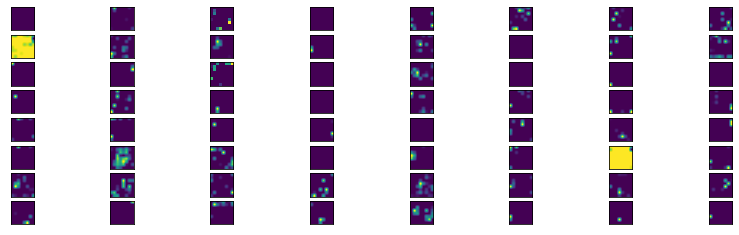

teacher 10th training
Epoch 1/15
313/313 - 22s - loss: 5.9059 - teacher_metric: 0.7722 - val_loss: 8.7474 - val_teacher_metric: 0.5679
Epoch 2/15
313/313 - 22s - loss: 5.7824 - teacher_metric: 0.7880 - val_loss: 8.7714 - val_teacher_metric: 0.5716
Epoch 3/15
313/313 - 22s - loss: 5.7181 - teacher_metric: 0.7953 - val_loss: 8.8161 - val_teacher_metric: 0.5671
Epoch 4/15
313/313 - 23s - loss: 5.6541 - teacher_metric: 0.8028 - val_loss: 8.9225 - val_teacher_metric: 0.5681
Epoch 5/15
313/313 - 22s - loss: 5.6287 - teacher_metric: 0.8085 - val_loss: 8.9822 - val_teacher_metric: 0.5652
Epoch 6/15
313/313 - 22s - loss: 5.6919 - teacher_metric: 0.8022 - val_loss: 9.0312 - val_teacher_metric: 0.5613
Epoch 7/15
313/313 - 23s - loss: 5.6593 - teacher_metric: 0.8069 - val_loss: 8.9911 - val_teacher_metric: 0.5649
Epoch 8/15
313/313 - 23s - loss: 5.6215 - teacher_metric: 0.8133 - val_loss: 8.9968 - val_teacher_metric: 0.5671
Epoch 9/15
313/313 - 22s - loss: 5.6095 - teacher_metric: 0.8138 - val_los

In [8]:
student_epoch=9
teacher_epoch=15
iteration=10
batchsize=128 
#Alpha=0.4
Temperature=7
student, teacher, s_d_val_loss, s_d_val_acc, t_d_val_loss, t_d_val_acc=distillation2(student_epoch, teacher_epoch, iteration, batchsize, Temperature)

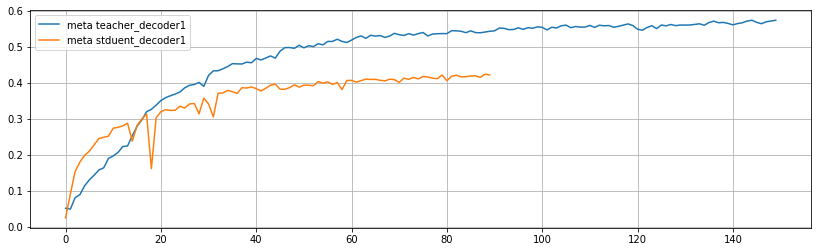

In [9]:
x_len= np.arange(teacher_epoch*iteration)
empty= np.zeros((teacher_epoch-student_epoch)*iteration)

empty[:]=np.NaN
s_d_val_acc_2= np.hstack([s_d_val_acc,empty])

np.save('D:/Dropbox/나메렝/wml/210522/conv4/RTloss2_student.npy', s_d_val_acc_2)
np.save('D:/Dropbox/나메렝/wml/210522/conv4/RTloss2_teacher.npy', t_d_val_acc)

plt.plot(x_len, t_d_val_acc, '-', label='meta teacher_decoder1')
plt.plot(x_len, s_d_val_acc_2, '-', label='meta stduent_decoder1')


plt.legend()
plt.grid()
plt.show()

In [231]:
# m= Model(student.input, student.layers[34].output)
# m.compile(optimizer=sgd_s, loss= 'categorical_crossentropy', metrics='accuracy')
# m.evaluate(x_test_100, y_test_fine, batch_size=128)

In [84]:

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
tf.get_logger().setLevel('ERROR')

inputs= Input(shape=(32,32,3))

initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1., seed=0)
x= Conv2D(64,(3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.0005), kernel_initializer=initializer)(inputs)
x= BatchNormalization()(x)
x= Dropout(0.3)(x)

x= Conv2D(64,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005))(x)
x= BatchNormalization()(x) 

x=MaxPooling2D(pool_size=(2,2))(x)

x=Conv2D(128,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005))(x)
x=BatchNormalization()(x)
x=Dropout(0.4)(x)

x=Conv2D(128,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005))(x)
x=BatchNormalization()(x)

x=MaxPooling2D(pool_size=(2,2))(x)

x=Conv2D(256,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005), input_shape= (8,8,128))(x)
x=BatchNormalization()(x)
x=Dropout(0.4)(x)

x=Conv2D(256,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005))(x)
x=BatchNormalization()(x)
hidden=Dropout(0.4)(x)

hidden2=tf.stop_gradient(hidden)


x=Flatten()(hidden)
x=Dense(128, kernel_regularizer=regularizers.l2(0.0005))(x)
x=Activation('relu')(x)
x=BatchNormalization()(x)
x=Dropout(0.5)(x)
x=Dense(128, kernel_regularizer=regularizers.l2(0.0005))(x)
x=Activation('relu')(x)
x=Dropout(0.5)(x)

out_logit=Dense(100)(x)
out_c=Activation('softmax')(out_logit)


### Decoder1 
# d= Conv2D(12,(3,3), strides=(1,1))(hidden)
# d=Activation('relu')(d)
# d=keras.layers.ZeroPadding2D(padding=6)(d)
# d=BatchNormalization()(d)
# d=Conv2D(3,(3,3), strides=(1,1))(d)
# d=keras.layers.ZeroPadding2D(padding=8)(d)
# d=Activation('sigmoid')(d)
# out_d=BatchNormalization()(d)



### Decoder 2 (논문에서 사용)\
def resize(hidden):
    return tf.image.resize(hidden, (32,32), method=tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio=True)
cv1=Conv2D(12,(3,3), strides=(1,1), padding='same', kernel_initializer=initializer)
bn1=BatchNormalization()
act1= Activation('relu')
cv2= Conv2D(3, (3,3), strides=(1,1), padding='same')
act2= Activation('sigmoid')


d= resize(hidden)
d= cv1(d)
d= bn1(d)
d= act1(d)
d= cv2(d)
out_d= act2(d)

d2= resize(hidden2)
d2= cv1(d2)
d2= bn1(d2)
d2= act1(d2)
d2= cv2(d2)
out_d2= act2(d2)

#이렇게 하면 weight 두개 똑같은가   --> 똑같다

### Decoder 2 (논문에서 사용)\
# d= tf.image.resize(hidden2, (32,32), method=tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio=True)
# d= Conv2D(12,(3,3), strides=(1,1), padding='same')(d)
# d= BatchNormalization()(d)
# d= Activation('relu')(d)
# d= Conv2D(3, (3,3), strides=(1,1), padding='same')(d)
# out_d= Activation('sigmoid')(d)

# model_3= Model(inputs=inputs, outputs= out_d)  #hidden2
# loss_3= x_train이랑 얘가 뽑은 output 의 차이
# model_1= Model(inputs=inputs, outputs= out_d)  #hidden 
# loss_1= x_train이랑 얘가 뽑은 output 의 차이
# model_2= Model(inputs=inputs, outputs= out_c)  #hidden? hidden2?  이거에 따른 성능 차이가 있을까
# loss_2= y_train이랑 얘가 뽑은 output 의 차이

model=Model(inputs, [out_d2, out_d, out_c])

def loss_decoder(y_true, y_pred):
    loss= keras.losses.binary_crossentropy(y_true, y_pred)
    return loss
def metric_decoder(y_true, y_pred):
    metric= keras.metrics.binary_accuracy(y_true, y_pred)
    return metric

def loss_student_decoder(y_true, y_pred):
    loss= keras.losses.binary_crossentropy(y_true, y_pred)
    return loss
def metric_student_decoder(y_true, y_pred):
    metric= keras.metrics.binary_accuracy(y_true, y_pred)
    return metric

def loss_classifier(y_true, y_pred):
    loss= keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.AUTO, from_logits=False)(y_true,y_pred)
    return loss

def metric_classifier(y_true, y_pred):
    metric= keras.metrics.categorical_accuracy(y_true, y_pred)
    return metric

lr_s= 0.001
batchsize=128
student_epochs=30
lr_drop= 20
opt_s= optimizers.Adam(learning_rate= lr_s)
def lr_scheduler(student_epoch):
    return lr_s * (0.5 ** (student_epoch // lr_drop))
reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)
        
model.compile(optimizer= opt_s, loss= [loss_decoder, loss_student_decoder, loss_classifier], 
              metrics=['accuracy'])
# history=model.fit(x_train_100, [x_train_100, x_train_100, y_train_fine], batch_size= batchsize, 
#           epochs=student_epochs, callbacks=[reduce_lr], 
#           validation_split=0.2, shuffle=False, verbose=2)


Epoch 1/30
313/313 - 41s - loss: -1.7086e+01 - activation_179_loss: -1.1439e+01 - activation_179_1_loss: -1.1439e+01 - activation_177_loss: 4.7087 - activation_179_accuracy: 0.4174 - activation_179_1_accuracy: 0.4174 - activation_177_accuracy: 0.0284 - val_loss: -6.3699e+01 - val_activation_179_loss: -3.4385e+01 - val_activation_179_1_loss: -3.4385e+01 - val_activation_177_loss: 4.2021 - val_activation_179_accuracy: 0.4298 - val_activation_179_1_accuracy: 0.4298 - val_activation_177_accuracy: 0.0822
Epoch 2/30
313/313 - 43s - loss: -1.0719e+02 - activation_179_loss: -5.6139e+01 - activation_179_1_loss: -5.6139e+01 - activation_177_loss: 4.3116 - activation_179_accuracy: 0.4502 - activation_179_1_accuracy: 0.4502 - activation_177_accuracy: 0.0551 - val_loss: -2.1654e+02 - val_activation_179_loss: -1.1066e+02 - val_activation_179_1_loss: -1.1066e+02 - val_activation_177_loss: 4.0635 - val_activation_179_accuracy: 0.4918 - val_activation_179_1_accuracy: 0.4918 - val_activation_177_accurac

Epoch 18/30
313/313 - 38s - loss: -8.1748e+03 - activation_179_loss: -4.0902e+03 - activation_179_1_loss: -4.0902e+03 - activation_177_loss: 3.8801 - activation_179_accuracy: 0.5511 - activation_179_1_accuracy: 0.5511 - activation_177_accuracy: 0.1147 - val_loss: -8.4686e+03 - val_activation_179_loss: -4.2370e+03 - val_activation_179_1_loss: -4.2370e+03 - val_activation_177_loss: 3.7652 - val_activation_179_accuracy: 0.5532 - val_activation_179_1_accuracy: 0.5532 - val_activation_177_accuracy: 0.1422
Epoch 19/30
313/313 - 38s - loss: -8.9896e+03 - activation_179_loss: -4.4976e+03 - activation_179_1_loss: -4.4976e+03 - activation_177_loss: 3.8775 - activation_179_accuracy: 0.5511 - activation_179_1_accuracy: 0.5511 - activation_177_accuracy: 0.1142 - val_loss: -9.3021e+03 - val_activation_179_loss: -4.6538e+03 - val_activation_179_1_loss: -4.6538e+03 - val_activation_177_loss: 3.7588 - val_activation_179_accuracy: 0.5532 - val_activation_179_1_accuracy: 0.5532 - val_activation_177_accur

In [48]:
def teacher_alone_model(num_classes):

    global Temperature, sgd_t, y_true, y_pred

    teacher= Sequential()

    teacher.add(Conv2D(64,(3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.0005), input_shape= (32,32,3)))
    teacher.add(BatchNormalization())
    teacher.add(Dropout(0.3))

    teacher.add(Conv2D(64,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    teacher.add(BatchNormalization()) 

    teacher.add(MaxPooling2D(pool_size=(2,2)))

    teacher.add(Conv2D(128,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    teacher.add(BatchNormalization())
    teacher.add(Dropout(0.4))

    teacher.add(Conv2D(128,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    teacher.add(BatchNormalization())

    teacher.add(MaxPooling2D(pool_size=(2,2)))

    teacher.add(Conv2D(256,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    teacher.add(BatchNormalization())
    teacher.add(Dropout(0.4))

    teacher.add(Conv2D(256,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    teacher.add(BatchNormalization())
    teacher.add(Dropout(0.4))

    teacher.add(Conv2D(256,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    teacher.add(BatchNormalization()) 

    teacher.add(MaxPooling2D(pool_size=(2,2)))

    teacher.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    teacher.add(BatchNormalization())
    teacher.add(Dropout(0.4))

    teacher.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    teacher.add(BatchNormalization())
    teacher.add(Dropout(0.4))

    teacher.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    teacher.add(BatchNormalization())


    teacher.add(MaxPooling2D(pool_size=(2,2)))

    teacher.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    teacher.add(BatchNormalization())
    teacher.add(Dropout(0.4))

    teacher.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    teacher.add(BatchNormalization())
    teacher.add(Dropout(0.4))

    teacher.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    teacher.add(BatchNormalization())

    teacher.add(MaxPooling2D(pool_size=(2,2)))
    teacher.add(Dropout(0.5))

    teacher.add(Flatten())
    teacher.add(Dense(128, kernel_regularizer=regularizers.l2(0.0005)))
    teacher.add(Activation('relu'))
    teacher.add(BatchNormalization())
    teacher.add(Dropout(0.5))
    teacher.add(Dense(128, kernel_regularizer=regularizers.l2(0.0005)))
    teacher.add(Activation('relu'))
    teacher.add(Dropout(0.5))

    teacher.add(Dense(num_classes))
    teacher.add(Activation('softmax'))

    teacher.compile(optimizer=sgd_t, loss=['categorical_crossentropy'], metrics=['accuracy'])


    return teacher


num_classes_t= num_classes_fine
lr_t= 0.01
lr_decay= 1e-6
batchsize=128
weight_decay= 0.0005
lr_drop=20
teacher_epoch=150


#models

sgd_t= optimizers.SGD(learning_rate= lr_t, decay= lr_decay, momentum=0.9, nesterov=True)
teacher_alone= teacher_alone_model(num_classes_fine)


def lr_scheduler(teacher_epoch):
    return lr_t * (0.5 ** (teacher_epoch // lr_drop))
reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)


history_t_a= teacher_alone.fit(x_train_100, y_train_fine, batch_size= batchsize,
                       epochs= teacher_epoch, callbacks=[reduce_lr],
                       validation_split=0.2, shuffle=False, verbose=2)
np.save('D:/Dropbox/나메렝\wml/210522/conv4/teacher alone.npy', history_t_a.history['val_accuracy'])

Epoch 1/150
313/313 - 26s - loss: 7.1246 - accuracy: 0.0116 - val_loss: 6.8473 - val_accuracy: 0.0179
Epoch 2/150
313/313 - 25s - loss: 6.7633 - accuracy: 0.0212 - val_loss: 6.6207 - val_accuracy: 0.0209
Epoch 3/150
313/313 - 25s - loss: 6.5101 - accuracy: 0.0266 - val_loss: 6.3987 - val_accuracy: 0.0257
Epoch 4/150
313/313 - 25s - loss: 6.2877 - accuracy: 0.0327 - val_loss: 6.3413 - val_accuracy: 0.0268
Epoch 5/150
313/313 - 25s - loss: 6.0858 - accuracy: 0.0383 - val_loss: 6.0737 - val_accuracy: 0.0422
Epoch 6/150
313/313 - 25s - loss: 5.8992 - accuracy: 0.0462 - val_loss: 5.8657 - val_accuracy: 0.0480
Epoch 7/150
313/313 - 25s - loss: 5.7228 - accuracy: 0.0533 - val_loss: 5.8021 - val_accuracy: 0.0509
Epoch 8/150
313/313 - 25s - loss: 5.5581 - accuracy: 0.0625 - val_loss: 5.8370 - val_accuracy: 0.0595
Epoch 9/150
313/313 - 25s - loss: 5.4004 - accuracy: 0.0718 - val_loss: 5.5901 - val_accuracy: 0.0628
Epoch 10/150
313/313 - 25s - loss: 5.2472 - accuracy: 0.0804 - val_loss: 5.3846 - 

Epoch 81/150
313/313 - 25s - loss: 1.4851 - accuracy: 0.7668 - val_loss: 3.2626 - val_accuracy: 0.5598
Epoch 82/150
313/313 - 25s - loss: 1.4482 - accuracy: 0.7778 - val_loss: 3.2827 - val_accuracy: 0.5627
Epoch 83/150
313/313 - 25s - loss: 1.4110 - accuracy: 0.7879 - val_loss: 3.2531 - val_accuracy: 0.5664
Epoch 84/150
313/313 - 25s - loss: 1.3989 - accuracy: 0.7893 - val_loss: 3.2624 - val_accuracy: 0.5688
Epoch 85/150
313/313 - 25s - loss: 1.3772 - accuracy: 0.7977 - val_loss: 3.3045 - val_accuracy: 0.5642
Epoch 86/150
313/313 - 25s - loss: 1.3813 - accuracy: 0.7929 - val_loss: 3.3143 - val_accuracy: 0.5681
Epoch 87/150
313/313 - 25s - loss: 1.3657 - accuracy: 0.7976 - val_loss: 3.3149 - val_accuracy: 0.5689
Epoch 88/150
313/313 - 26s - loss: 1.3462 - accuracy: 0.8066 - val_loss: 3.3655 - val_accuracy: 0.5624
Epoch 89/150
313/313 - 25s - loss: 1.3453 - accuracy: 0.8070 - val_loss: 3.3632 - val_accuracy: 0.5718
Epoch 90/150
313/313 - 25s - loss: 1.3341 - accuracy: 0.8077 - val_loss: 

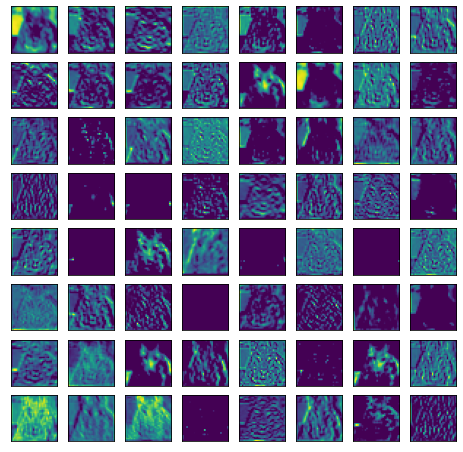

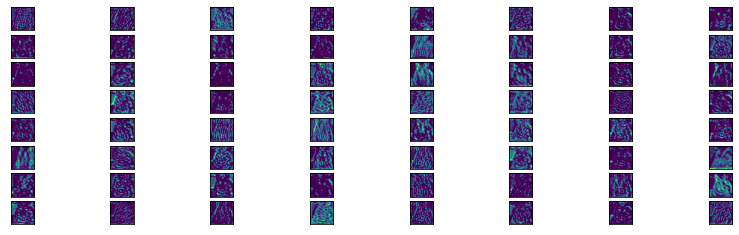

In [45]:
#teacher alone hidden
teacher_hidden= Model(inputs=teacher_alone.input, outputs= teacher_alone.layers[1].output)

pic=x_train_100[5000]
pic = np.expand_dims(pic, axis=0)
feature= teacher_hidden.predict(pic)

square=8
ix=1
for fmap in feature:
    for _ in range(square):
        for _ in range(square):
            ax= plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.rcParams["figure.figsize"] = (8,8)
            plt.imshow(fmap[:,:,ix-1])
            ix=ix+1
plt.rcParams["figure.figsize"] = (14,4)
plt.show()



teacher_hidden= Model(inputs=teacher_alone.input, outputs= teacher_alone.layers[3].output)

pic=x_train_100[5000]
pic = np.expand_dims(pic, axis=0)
feature= teacher_hidden.predict(pic)

square=8
ix=1
for fmap in feature:
    for _ in range(square):
        for _ in range(square):
            ax= plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.rcParams["figure.figsize"] = (8,8)
            plt.imshow(fmap[:,:,ix-1])
            ix=ix+1
  #plt.rcParams["figure.figsize"] = (14,4)
plt.show()

In [ ]:
#teacher alone hidden

teacher_hidden_2= Model(inputs=teacher_alone.input, outputs= teacher_alone.layers[36].output)
print(teacher_alone.layers[17])
pic=x_train_100[5000]
pic = np.expand_dims(pic, axis=0)
feature= teacher_hidden_2.predict(pic)

col=16
row=32
ix=1
for fmap in feature:
    for _ in range(square):
        for _ in range(square):
            ax= plt.subplot(col,row, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.rcParams["figure.figsize"] = (8,8)
            plt.imshow(fmap[:,:,ix-1])
            ix=ix+1
  #plt.rcParams["figure.figsize"] = (14,4)
plt.show()

In [ ]:

student_hidden= Model(inputs=student.input, outputs= student.layers[18].output)

pic=x_train_100[5000]
pic = np.expand_dims(pic, axis=0)
feature= student_hidden.predict(pic)

square=16
ix=1
for fmap in feature:
    for _ in range(square):
        for _ in range(square):
            ax= plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.rcParams["figure.figsize"] = (8,8)
            plt.imshow(fmap[:,:,ix-1])
            ix=ix+1
plt.rcParams["figure.figsize"] = (14,4)
plt.show()

In [ ]:
# Meta+CTloss

Temperature= 7
num_classes_fine=100
num_classes_s = 100
num_classes_t= 100
lr_t= 0.01
lr_s= 0.001
lr_decay= 1e-6
batchsize=128
weight_decay= 0.0005
lr_drop=20
    

sgd_s= optimizers.Adam(learning_rate= lr_s)


meta_student=student_model(100)
meta_student.load_weights(filepath='D:/Dropbox/나메렝/wml/210515/cifar100_stconv6/meta_student_ctloss2_model.h5')

hidden= Model(inputs= meta_student.input, outputs= meta_student.layers[18].output)

pic=x_train_100[5000]
pic = np.expand_dims(pic, axis=0)

feature_h= hidden.predict(pic)
square=16
ix=1
for fmap in feature_h:
    for _ in range(square):
        for _ in range(square):
            ax= plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.rcParams["figure.figsize"] = (8,8)
            plt.imshow(fmap[:,:,ix-1])
            ix=ix+1
  #plt.rcParams["figure.figsize"] = (14,4)
plt.show()

In [66]:

def student_alone_model(num_classes):
    
    global sgd_s_a, y_true, y_pred, Temperature, Alpha
    student= Sequential()

    student.add(Conv2D(64,(3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.0005), input_shape=(32,32,3)))
    student.add(BatchNormalization())
    student.add(Dropout(0.3))

    student.add(Conv2D(64,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    student.add(BatchNormalization()) 

    student.add(MaxPooling2D(pool_size=(2,2)))

    student.add(Conv2D(128,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    student.add(BatchNormalization())
    student.add(Dropout(0.4))

    student.add(Conv2D(128,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    student.add(BatchNormalization())

    student.add(MaxPooling2D(pool_size=(2,2)))

    student.add(Flatten())
    student.add(Dense(128, kernel_regularizer=regularizers.l2(0.0005)))
    student.add(Activation('relu'))
    student.add(BatchNormalization())
    student.add(Dropout(0.5))
    student.add(Dense(128, kernel_regularizer=regularizers.l2(0.0005)))
    student.add(Activation('relu'))
    student.add(Dropout(0.5))

    student.add(Dense(num_classes))
    student.add(Activation('softmax'))
 
    student.compile(optimizer=sgd_s_a, loss=['categorical_crossentropy'], metrics=['accuracy'])

    return student


lr_s=0.001
num_classes_s=num_classes_fine
student_a_epoch=90
lr_drop=20
lr_decay= 1e-6
weight_decay= 0.0005

#sgd= optimizers.SGD(learning_rate= lr_s, decay= lr_decay, momentum=0.9, nesterov=True)
sgd_s_a= optimizers.Adam(learning_rate= lr_s)
student_alone= student_alone_model(num_classes_s)


history_s_a= student_alone.fit(x_train_100, y_train_fine, batch_size=128, epochs=student_a_epoch, validation_split=0.2, shuffle=False, verbose=2)
#np.save('D:/Dropbox/나메렝/wml/210522/conv4/student_alone.npy', history_s_a.history['val_accuracy'])

Epoch 1/90
313/313 - 14s - loss: 4.7570 - accuracy: 0.0446 - val_loss: 4.6950 - val_accuracy: 0.0440
Epoch 2/90
313/313 - 13s - loss: 4.1520 - accuracy: 0.1019 - val_loss: 3.7863 - val_accuracy: 0.1677
Epoch 3/90
313/313 - 13s - loss: 3.8412 - accuracy: 0.1403 - val_loss: 3.4237 - val_accuracy: 0.2335
Epoch 4/90
313/313 - 13s - loss: 3.5730 - accuracy: 0.1819 - val_loss: 3.2867 - val_accuracy: 0.2521
Epoch 5/90
313/313 - 13s - loss: 3.3698 - accuracy: 0.2202 - val_loss: 3.0635 - val_accuracy: 0.2989
Epoch 6/90
313/313 - 13s - loss: 3.2313 - accuracy: 0.2517 - val_loss: 3.0148 - val_accuracy: 0.3018
Epoch 7/90
313/313 - 13s - loss: 3.1390 - accuracy: 0.2759 - val_loss: 3.0438 - val_accuracy: 0.3156
Epoch 8/90
313/313 - 13s - loss: 3.0683 - accuracy: 0.3044 - val_loss: 3.0406 - val_accuracy: 0.3313
Epoch 9/90
313/313 - 13s - loss: 3.0317 - accuracy: 0.3201 - val_loss: 2.8338 - val_accuracy: 0.3851
Epoch 10/90
313/313 - 13s - loss: 2.9831 - accuracy: 0.3374 - val_loss: 2.8739 - val_accura

KeyboardInterrupt: 

In [67]:

def student_distill_model(num_classes):
    
    global sgd, y_true, y_pred, Temperature, Alpha
    student= Sequential()

    student.add(Conv2D(64,(3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.0005), input_shape=(32,32,3)))
    student.add(BatchNormalization())
    student.add(Dropout(0.3))

    student.add(Conv2D(64,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    student.add(BatchNormalization()) 

    student.add(MaxPooling2D(pool_size=(2,2)))

    student.add(Conv2D(128,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    student.add(BatchNormalization())
    student.add(Dropout(0.4))

    student.add(Conv2D(128,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    student.add(BatchNormalization())

    student.add(MaxPooling2D(pool_size=(2,2)))


    student.add(Flatten())
    student.add(Dense(128, kernel_regularizer=regularizers.l2(0.0005)))
    student.add(Activation('relu'))
    student.add(BatchNormalization())
    student.add(Dropout(0.5))
    student.add(Dense(128, kernel_regularizer=regularizers.l2(0.0005)))
    student.add(Activation('relu'))
    student.add(Dropout(0.5))

    student.add(Dense(num_classes))
    #student.add(Activation('softmax'))
    
#     student_logits= student.layers[-1].output  
#     probs= Activation('softmax')(student_logits)                     # hard prediction
#     logits_T= Lambda(lambda x:x/Temperature)(student_logits)         #z/T
#     probs_T= Activation('softmax')(logits_T)                         # soft prediction
    
    
    student_logits= student.layers[-1].output  
    probs= Activation('softmax')(student_logits)                     # hard prediction
    logits_T= Lambda(lambda x:x/Temperature)(student_logits)         #z/T
    probs_T= Activation('softmax')(logits_T)                         # soft prediction

    CombinedLayers= concatenate([probs, probs_T])
    student= Model(student.input, CombinedLayers)
    student.compile(optimizer=sgd_s, loss=lambda y_true,y_pred: student_distill_loss(y_true, y_pred, T=Temperature), metrics=student_distill_metric)

    return student

In [88]:
def student_distill_loss(y_true, y_pred, T):
    global num_classes_s, Alpha, Beta
    y_true, y_true_soft= y_true[:,:num_classes_s], y_true[:, num_classes_s:]
    y_pred, y_pred_soft= y_pred[:,:num_classes_s], y_pred[:, num_classes_s:]
    
    #cross-entropy loss (temperatureX)
    #CE_loss = categorical_crossentropy(y_true,y_pred)
    CE_loss= keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.AUTO, from_logits=False)(y_true,y_pred)
    
    #KL-divergence loss (temperatureO)
    KL_loss = (T**2)*(kullback_leibler_divergence(y_true_soft, y_pred_soft))
    
    m= (y_true_soft + y_pred_soft)/2
    JS_loss= (kullback_leibler_divergence(y_true_soft, m) + kullback_leibler_divergence(y_pred_soft, m))/2
    
    WS_loss= K.mean(y_true_soft * y_pred_soft)
    
    return Alpha*CE_loss + Beta*WS_loss

def student_distill_metric(y_true, y_pred):
    y_true, y_true_soft= y_true[:,:num_classes_s], y_true[:, num_classes_s:]
    y_pred, y_pred_soft= y_pred[:,:num_classes_s], y_pred[:, num_classes_s:]
    
    return keras.metrics.categorical_accuracy(y_true, y_pred)

In [89]:
lr_s=0.001
num_classes_s=num_classes_fine
sgd_s= optimizers.Adam(learning_rate= lr_s)
student_distill= student_distill_model(num_classes_s)

out_s= Model(inputs= teacher_alone.input, outputs= teacher_alone.layers[-1].output)  #48
Temperature=3
Alpha=1
Beta=1
batchsize=128
student_epoch=90


# x_1= x_train_100[:10000]
# s_1= out_s.predict(x_1, batch_size=2)
# logits_1= Lambda(lambda x:x/Temperature)(s_1)
# probs_1= Activation('softmax')(logits_1)
# print('1')

# x_2= x_train_100[10000:20000]
# s_2= out_s.predict(x_2, batch_size=2)
# logits_2= Lambda(lambda x:x/Temperature)(s_2)
# probs_2= Activation('softmax')(logits_2)
# s_output= np.vstack([probs_1,probs_2])
# print('2')

# x_3= x_train_100[20000:30000]
# s_3= out_s.predict(x_3, batch_size=2)
# logits_3= Lambda(lambda x:x/Temperature)(s_3)
# probs_3= Activation('softmax')(logits_3)
# s_output= np.vstack([s_output,probs_3])
# print('3')

# x_4= x_train_100[30000:40000]
# s_4= out_s.predict(x_4, batch_size=2)
# logits_4= Lambda(lambda x:x/Temperature)(s_4)
# probs_4= Activation('softmax')(logits_4)
# s_output= np.vstack([s_output,probs_4])
# print('4')

# x_5= x_train_100[40000:]
# s_5= out_s.predict(x_5, batch_size=2)
# logits_5= Lambda(lambda x:x/Temperature)(s_5)
# probs_5= Activation('softmax')(logits_5)
# s_output= np.vstack([s_output,probs_5])
# print('5')



# y_train_new= np.c_[y_train_fine, s_output]

history_s_d= student_distill.fit(x_train_100, y_train_new, batch_size= batchsize,
                       epochs= student_epoch, validation_split=0.2, shuffle=False, verbose=2)

# Alpha=2로
#loss 2배로 하면되나

C:\Users\hyeli\Anaconda3\envs\hlnam\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3508: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/90
313/313 - 17s - loss: 4.7686 - student_distill_metric: 0.0479 - val_loss: 4.8154 - val_student_distill_metric: 0.0342
Epoch 2/90
313/313 - 17s - loss: 4.1621 - student_distill_metric: 0.1040 - val_loss: 3.7470 - val_student_distill_metric: 0.1785
Epoch 3/90
313/313 - 17s - loss: 3.8014 - student_distill_metric: 0.1513 - val_loss: 3.3745 - val_student_distill_metric: 0.2402
Epoch 4/90
313/313 - 16s - loss: 3.5203 - student_distill_metric: 0.1997 - val_loss: 3.1270 - val_student_distill_metric: 0.2793
Epoch 5/90
313/313 - 17s - loss: 3.3103 - student_distill_metric: 0.2389 - val_loss: 3.0252 - val_student_distill_metric: 0.3092
Epoch 6/90
313/313 - 18s - loss: 3.1905 - student_distill_metric: 0.2664 - val_loss: 3.0231 - val_student_distill_metric: 0.3262
Epoch 7/90
313/313 - 16s - loss: 3.1026 - student_distill_metric: 0.2970 - val_loss: 2.8353 - val_student_distill_metric: 0.3653
Epoch 8/90
313/313 - 16s - loss: 3.0323 - student_distill_metric: 0.3212 - val_loss: 2.8839 - val

313/313 - 16s - loss: 2.5283 - student_distill_metric: 0.5465 - val_loss: 2.9105 - val_student_distill_metric: 0.4875
Epoch 65/90
313/313 - 16s - loss: 2.5250 - student_distill_metric: 0.5480 - val_loss: 2.8975 - val_student_distill_metric: 0.4877
Epoch 66/90
313/313 - 16s - loss: 2.5249 - student_distill_metric: 0.5499 - val_loss: 2.9272 - val_student_distill_metric: 0.4882
Epoch 67/90
313/313 - 16s - loss: 2.5056 - student_distill_metric: 0.5557 - val_loss: 2.9322 - val_student_distill_metric: 0.4906
Epoch 68/90
313/313 - 16s - loss: 2.5209 - student_distill_metric: 0.5488 - val_loss: 2.9854 - val_student_distill_metric: 0.4735
Epoch 69/90
313/313 - 16s - loss: 2.5157 - student_distill_metric: 0.5507 - val_loss: 2.9140 - val_student_distill_metric: 0.4856
Epoch 70/90
313/313 - 16s - loss: 2.5153 - student_distill_metric: 0.5541 - val_loss: 2.9364 - val_student_distill_metric: 0.4803
Epoch 71/90
313/313 - 16s - loss: 2.5215 - student_distill_metric: 0.5523 - val_loss: 2.8980 - val_stu

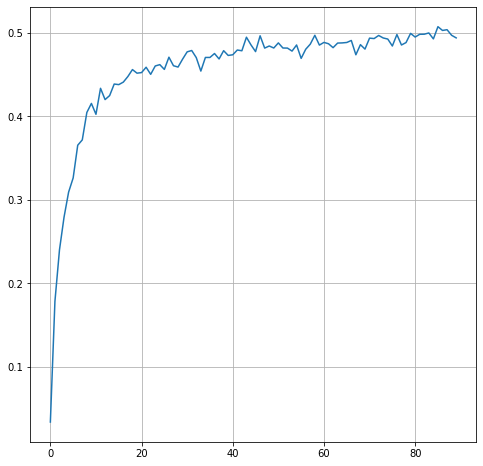

In [90]:
np.save('D:/Dropbox/나메렝/wml/210522/distill/alpha1beta1_3_wsloss.npy', history_s_d.history['val_student_distill_metric'])
x_len=np.arange(90)
plt.plot(x_len, history_s_d.history['val_student_distill_metric'])
plt.grid()
plt.show()

In [ ]:
x_len= np.arange(150)
empty= np.zeros(60)
empty[:]=np.NaN
#s_alone= np.hstack([history_s_a.history['val_accuracy'],empty])
# s_distill_alp5temp7_ccloss= np.hstack([history_s_d.history['val_accuracy'],empty])
#s_distill_alp5temp7_hiddenfeature= np.hstack([history_s_d.history['val_accuracy'],empty])

#np.save('D:/Dropbox/나메렝/wml/210515/cifar100_stconv6/student_alone.npy', s_alone)
#np.save('D:/Dropbox/나메렝/wml/210515/cifar100_stconv6/student_distill_alp5temp7.npy', s_distill_alp5temp7)
#np.save('D:/Dropbox/나메렝/wml/210515/cifar100_stconv6/teacher_alone.npy', history_t_a.history['val_accuracy'])

ct_student= np.load('D:/Dropbox/나메렝/wml/210515/cifar100_stconv6/meta_student_ctloss_2.npy')
ct_teacher= np.load('D:/Dropbox/나메렝/wml/210515/cifar100_stconv6/meta_teacher_ctloss_2.npy')
student_alone=np.load('D:/Dropbox/나메렝/wml/210515/cifar100_stconv6/student_alone.npy')
teacher_alone=np.load('D:/Dropbox/나메렝/wml/210515/cifar100_stconv6/teacher_alone.npy')
meta_student_h_c= np.load('D:/Dropbox/나메렝/wml/210515/cifar100_stconv6/meta_student_hidden_alphacontrol.npy')
meta_teacher_h_c= np.load('D:/Dropbox/나메렝/wml/210515/cifar100_stconv6/meta_teacher_hidden_alphacontrol.npy')
meta_student_h= np.load('D:/Dropbox/나메렝/wml/210515/cifar100_stconv6/meta_student_hidden.npy')
meta_teacher_h= np.load('D:/Dropbox/나메렝/wml/210515/cifar100_stconv6/meta_teacher_hidden.npy')
meta_student= np.load('D:/Dropbox/나메렝/wml/210515/cifar100_stconv6/meta_student.npy')
meta_teacher= np.load('D:/Dropbox/나메렝/wml/210515/cifar100_stconv6/meta_teacher.npy')

x_len= np.arange(150)
#plt.plot(x_len, meta_student, '-', label='student_output')
#plt.plot(x_len, meta_teacher, '-', label='teacher_output')
plt.plot(x_len, meta_student_h, '-', color='green', label='student_hidden')
plt.plot(x_len, meta_teacher_h, '-', color='forestgreen', label='teacher_hidden')
plt.plot(x_len, meta_student_h_c, '-', color='red', label='student_hidden_alphachange')
plt.plot(x_len, meta_teacher_h_c, '-', color='tomato', label='teacher_hidden_alphachange')
# plt.plot(x_len, student_alone, '-', color='black', label='student_alone')
# plt.plot(x_len, teacher_alone, '-', color='black', label='teacher_alone')
# plt.plot(x_len, ct_student, '-', linewidth=5, label='student_ct')
# plt.plot(x_len, ct_teacher, '-', linewidth=5, label='teacher_ct')

plt.rcParams["figure.figsize"] = (8,6)
plt.grid()
plt.legend()
plt.xlabel('num of epochs')
plt.ylabel('validation accuracy')
plt.show()

In [ ]:
def Decoder(model):
    print(model)
    #decoder= Sequential()
    
    if model.output.shape[1]==1:
        #decoder= Sequential()
        model.add(keras.layers.ZeroPadding2D(padding=2, input_shape=model.output.shape[1:]))
        model.add(Conv2D(12,(2,2), strides=(1,1), padding='valid'))
        model.add(Activation('relu'))
        model.add(keras.layers.ZeroPadding2D(padding=8))
        model.add(BatchNormalization())
        model.add(Conv2D(3,(3,3), strides=(1,1)))
        model.add(keras.layers.ZeroPadding2D(padding=7))
        model.add(Activation('sigmoid'))
        model.add(BatchNormalization())
    else:    
        if model.output.shape[1]==2:
            model.add(keras.layers.ZeroPadding2D(padding=1, input_shape=model.output.shape[1:]))
            padd=8
        else:
            padd=np.int((36-model.output.shape[1])/4)

        model.add(Conv2D(12,(3,3), strides=(1,1)))
        model.add(Activation('relu'))
        model.add(keras.layers.ZeroPadding2D(padding=padd))
        model.add(BatchNormalization())
        model.add(Conv2D(3,(3,3), strides=(1,1)))
        model.add(keras.layers.ZeroPadding2D(padding=padd))
        model.add(Activation('sigmoid'))
        model.add(BatchNormalization())

    return model


mutual_xz= np.zeros(40)
mutual_xz_loss= np.zeros(40)
for i in np.arange(40):
    out= Sequential()
    out.add(Input((32,32,3)))
    for lay in np.arange(i):
        out.add(teacher_alone.layers[lay])
    decoder= Decoder(out)
    
    decoder.compile(optimizer='sgd', loss=['binary_crossentropy'], metrics=['accuracy'])
    
    for layer in np.arange(i):
        decoder.layers[layer].trainable=False
    
    history_decoder= decoder.fit(x_train_100, x_train_100, batch_size= 128,
                                   epochs= 30, validation_split=0.2, shuffle=False, verbose=2)
    mutual_xz[i]=sum(history_decoder.history['val_loss'], 0.0) / len(history_decoder.history['val_loss'])
    mutual_xz_loss[i]=sum(history_decoder.history['loss'], 0.0) / len(history_decoder.history['loss'])

In [ ]:
#mutual_xz[-1]=4.01
x_len= np.arange(40)
plt.plot(x_len, mutual_xz, '.-')
#plt.plot(x_len, mutual_xz_loss, '.-', label='loss')
plt.xlabel('layer index')
plt.ylabel('reconstruction loss')
plt.title('I(x;z) estimation')
plt.legend()
plt.grid() 
plt.show()

In [ ]:
def Classifier(classifier):
    
#     if classifier.output.shape[1]<=2:
#         kernel=1
#     else:
#         kernel=3
    
#     classifier.add(Conv2D(12,(kernel,kernel), strides=(1,1), input_shape=classifier.output.shape[1:]))
#     classifier.add(Activation('relu'))
#     classifier.add(BatchNormalization())
    if len(classifier.output.shape)>2:
        classifier.add(Flatten())
        
    classifier.add(Dense(128))
    classifier.add(Activation('relu'))
    classifier.add(Dense(num_classes_fine))
    classifier.add(Activation('softmax'))
    
    return classifier


mutual_zy= np.zeros(len(teacher_alone.layers))  #모든 layer
mutual_zy_loss= np.zeros(len(teacher_alone.layers))
mutual_zy_acc= np.zeros(len(teacher_alone.layers))
for i in np.arange(len(teacher_alone.layers)):
    print('layer {}'.format(i))
    out= Sequential()
    out.add(Input((32,32,3)))
    for lay in np.arange(i):
        out.add(teacher_alone.layers[lay])
    classifier= Classifier(out)
    
    classifier.compile(optimizer='sgd', loss=['binary_crossentropy'], metrics=['accuracy'])
    
    for layer in np.arange(i):
        classifier.layers[layer].trainable=False
    
    history_classifier= classifier.fit(x_train_100, y_train_fine, batch_size= 128,
                                   epochs= 30, validation_split=0.2, shuffle=False, verbose=2)
    mutual_zy[i]=sum(history_classifier.history['val_loss'], 0.0) / len(history_classifier.history['val_loss'])
    mutual_zy_loss[i]=sum(history_classifier.history['loss'], 0.0) / len(history_classifier.history['loss'])
    mutual_zy_acc[i]=sum(history_classifier.history['val_accuracy'], 0.0) / len(history_classifier.history['val_accuracy'])

In [ ]:
#mutual_xy[-1]=4.01
x_len= np.arange(len(teacher_alone.layers))
plt.plot(x_len, mutual_zy, '.-', label='val_loss')
#plt.plot(x_len, mutual_zy_acc, '.-', label='val_acc')
plt.xlabel('layer index')
plt.ylabel('classification loss')
plt.title('I(z;y) estimation')
plt.legend()
plt.grid() 
plt.show()

In [ ]:
#mutual_xy[-1]=4.01
x_len= np.arange(len(teacher_alone.layers))
#plt.plot(x_len, mutual_zy, '.-', label='val_loss')
plt.plot(x_len, mutual_zy_acc, '.-', label='val_acc')
plt.xlabel('layer index')
plt.ylabel('classification loss')
plt.title('I(z;y) estimation')
plt.legend()
plt.grid() 
plt.show()